# Guided Example Bayesian calibration

Bellow is an adaptation of what we used in the "Practical Example" in the slides https://docs.google.com/presentation/d/1D5nX2ff5R820fJW5JmUiOvo6pEbZReGG/edit?usp=sharing&ouid=108123317698154395922&rtpof=true&sd=true. You can copy any parts of this file for your Bayesian Calibration. 

Some interesting questions you could also explore are:

- How does the posterior plots and the estimated parameters of your model depend on:
  -  The total number of Metropolis sampled (originally set to 100000)
  -  The total number of burning sampled (originally set to 1000)
  -  The step size used (originally set to 0.2 and 0.2)
  -  How many samples are skipped. Not originally implemented in the "Practical Example", you need to modify the Metropolis algorithm to only store every "m" samples.

- What happens with the previous questions if you change your true function and the model? You could explore quadratic or cubic polynomials, sines and cosines with some phase shifts, exponentials, or anything in your mind!

In [3]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy

#Some pretty colors I like
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [4]:
# Define the true function
#Note that we are going to fit a straight line, not the same as what generated the data. You can play with increasing
#the data range and see how things deteriorate

def true_function_A(x):
    return 2*x+0.1


In [5]:
#Generating the data and using a fixed seed to reproduce results

np.random.seed(142857)
data_A_x=np.array([0.5,0.6,0.7,0.75,0.8,0.9,1.1,1.2,1.5,1.7,2.0])
data_A_errors=np.array([0.3,0.3,0.6,0.3,0.3,0.6,0.6,0.3,0.3,0.6,1])
data_A_y=np.random.multivariate_normal(true_function_A(data_A_x),np.diag(data_A_errors)**2)


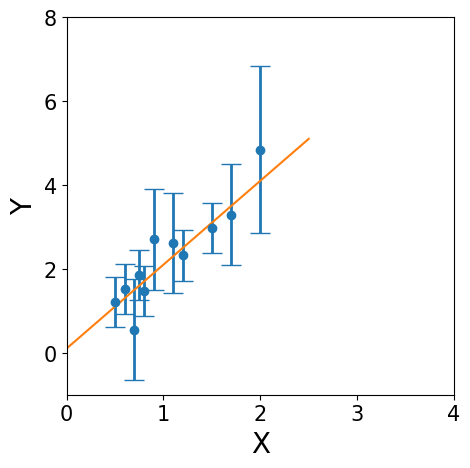

In [13]:
# Plot the data with error bars
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
ax.errorbar(data_A_x, data_A_y, yerr=2*data_A_errors, fmt='o', linewidth=2,capsize=7,label='Data [95% Errors]',color=colors[0])

x_func = np.linspace(0, 2.5, 100)

#If you want to see the true function that generated these, uncomment the following line
ax.plot(x_func, true_function_A(x_func), label='True Function',color=colors[1])

# plt.legend(fontsize=15,frameon=True, edgecolor='black')

# Set the axis labels and title
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
# ax.set_title('Data with Error Bars')

plt.xlim(0,4)
plt.ylim(-1,8)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.show()


<font size="5">
The model we will use to fit to this data set is:
    
    

$f(x,\alpha) = \alpha_1+\alpha_2x$

In [7]:
def model_A(x,params):
    return params[0]+params[1]*x

In [8]:

# Define the likelihood function for given errors sigma
def likelihood(params,arguments):
#Assumed format for data=[xvals,yvals]
    data, model, sigmas = arguments
    likelihood_log_val=0

    for i in range(len(data[0])):
        likelihood_log_val=likelihood_log_val-1/2*((data[1][i] - model(data[0][i],params)) / sigmas[i])**2\
        -np.log(2*np.pi*sigmas[i]**2)/2
      
        
    return np.exp(likelihood_log_val)

# Define the prior function
def prior_model_A(params_vals,arguments):
    params0,params0_Cov_Inv_matrix=arguments
    mu=np.array(params_vals)-np.array(params0)
    params_size=len(params_vals)
    return (2*np.pi)**(-params_size/2)*np.linalg.det(params0_Cov_Inv_matrix)**(-1)*np.exp(-np.dot(mu,np.dot(params0_Cov_Inv_matrix,mu))/2)



In [9]:
# Define the Metropolis algorithm
def metropolis(data,sigma, prior,prior_arguments, likelihood,model,\
               num_iterations, step_size):
#     step_size should be a list the size of the parameters of the model
    likelihood_arguments=[data, model, sigma]
    initial_parameters=prior_arguments[0]
    #thermalizing
    burn_samples=1000
    # Set the initial state of the chain
    params_current=initial_parameters
    params_list=[]
    posterior_list=[]
    
    acceptance_times=0
    
    cov_step_size=np.diag(step_size)**2
    
    posterior_current=(likelihood(params_current,likelihood_arguments))*(prior(params_current,\
                                                                               prior_arguments))
    
    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*(prior(params_proposed,\
                                                                               prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed


    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*\
        (prior(params_proposed,prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        params_list.append(params_current)
        posterior_list.append(posterior_current)
        
    
    #Rule of thumb acceptance is around 50%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print(acceptance_times/num_iterations*100,"%")
    
    return(np.array(params_list),np.array(posterior_list),\
           acceptance_times/num_iterations*100)



In [10]:
np.random.seed(142857)

#Setting up the prior
prior_arguments_A=[[0,1],np.linalg.inv(np.diag([2**2,2**2]))]

#Doing the Metropolis sampling for 100000 values
results_A=metropolis([data_A_x,data_A_y],data_A_errors, prior_model_A,\
                         prior_arguments_A, likelihood,model_A,100000, [0.2,0.2])
all_chains =results_A[0]

40.175 %


Lets plot the parameters we visited from the Metropolis algorithm using the corner package in python

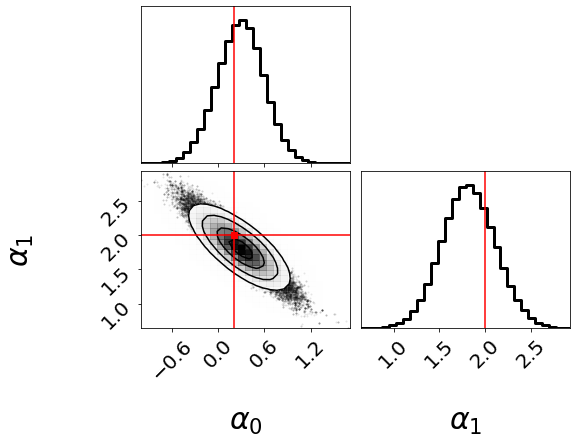

In [12]:

figure = corner.corner(all_chains,
    labels=[r'$\alpha_0$',r'$\alpha_1$'],
    labelpad=0.2,
                       bins=30,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
                       #This "truth" value shows what we used to generate the data
                       ,truths=[0.2,2], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)



Now is your turn! Find how these things change as you vary Monte Carlo details